### Control of Flying Drones Using Model Predictive Control (MPC) Technique

In this notebook, we will explore the use of Model Predictive Control (MPC) for controlling the flight of drones. MPC is a control technique that involves predicting the future behavior of a system and using this information to optimize the control inputs. It has become increasingly popular for a variety of applications, including drone control, due to its ability to handle complex systems and constraints. In this notebook, we will demonstrate how it can be applied to control a drone in a simulated environment. We will compare the performance of MPC to other control like RRT and RRT* and discuss the results.

In [2]:
# Imports
import numpy as np
import gym
import ipywidgets
from matplotlib import pyplot as plt

from MPC_control.linear_controller import LinearPDController
from MPC_control.nonlinear_controller import NonLinearPDController
from MPC_control.mpc_controller import MPCController
from MPC_control.Quadrotor import Quadrotor
from MPC_control.trajectory import CircleTrajectory, DiamondTrajectory, TUDTrajectory, HoverTrajectory

%matplotlib widget 

##### Choose Parameters:

In [3]:
trajectories = ["circle", "diamond", "TUD", "HOVER"]
trajectory_w = ipywidgets.RadioButtons(options=trajectories, description='Trajectory:')
controllers = ["nonlinear", "linear", "mpc"]
controller_w = ipywidgets.RadioButtons(options=controllers, description='Controller:')

items = [trajectory_w, controller_w]
box = ipywidgets.Box(children=items)

box 

Box(children=(RadioButtons(description='Trajectory:', options=('circle', 'diamond', 'TUD', 'HOVER'), value='ci…

#### Following trajectory with controller

Adapted from the Dynamics & Control practicum code.

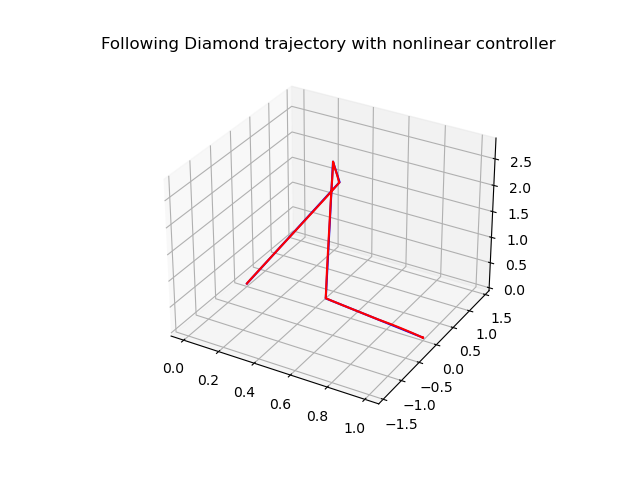

In [6]:
freq = 100 

dt = 1/freq
env = gym.make('Quadrotor-v0', disable_env_checker=True) # disable_env_checker to supress setup warnings

t = 0
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

simulation_time = 50

if trajectory_w.value == "circle":
    T=9
    trajectory = CircleTrajectory(dt, radius=5, end_z=2.5, T=T)
elif trajectory_w.value == "diamond":
    T=7
    trajectory = DiamondTrajectory(dt, end_x=1, T=T)
elif trajectory_w.value == "TUD":
    trajectory = TUDTrajectory(dt)
    ax.set_xlim(-0.1,0.1)
elif trajectory_w.value == "HOVER":
    T=3
    trajectory = HoverTrajectory(dt, hoverHeight=5, T=T)

if controller_w.value == "nonlinear":
    controller = NonLinearPDController()
elif controller_w.value == "linear":
    controller = LinearPDController()
elif controller_w.value == "mpc":
    controller = MPCController()

start_pos = trajectory.getDesState(t)['x']
end_pos = trajectory.getDesState(simulation_time)['x']
cur_state = env.reset(position=start_pos)

plan_trajectory = {'x' : [], 'y' : [], 'z' : []}
real_trajectory = {'x' : [], 'y' : [], 'z' : []}

while t < simulation_time:
    des_state = trajectory.getDesState(t)
    ctrl_var = controller.control(des_state, cur_state)
    action = ctrl_var['cmd_motor_speeds']
    cur_state, reward, done, info = env.step(action)

    plan_trajectory['x'].append(des_state['x'][0])
    plan_trajectory['y'].append(des_state['x'][1])
    plan_trajectory['z'].append(des_state['x'][2])

    cur_x = cur_state['x'][0]
    cur_y = cur_state['x'][1]
    cur_z = cur_state['x'][2]

    real_trajectory['x'].append(cur_x)
    real_trajectory['y'].append(cur_y)
    real_trajectory['z'].append(cur_z)

    t += dt

ax.set_title(f"Following {trajectory.getName()} trajectory with {controller_w.value} controller")
ax.plot(plan_trajectory['x'], plan_trajectory['y'], plan_trajectory['z'], c='#0000FF')
ax.plot(real_trajectory['x'], real_trajectory['y'], real_trajectory['z'], c='#FF0000')
plt.show()

#### RRT path planning with obstacles

Initialized RRT Planner with
startErrorMargin 75
goalErrorMargin 75
maxTimeTaken 10
maxNodesExpanded 10000
Found good enough end configuration Position (73, 76, 80) yaw 0.0 with error 74.86960440108936
Number of nodes expanded 271 and time taken 0.5754859447479248


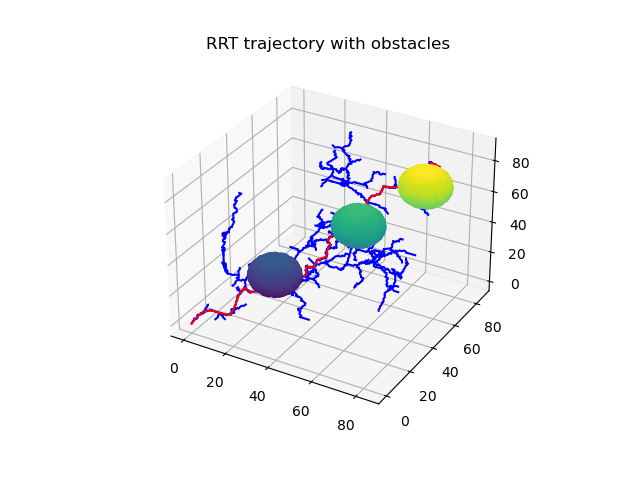

In [9]:
from RRT_planning.graphrrt import RRTPlanner, GridMap, Configuration

grid = GridMap(100,100,100)
grid.addObstacles(25,25,25, radius=10)
grid.addObstacles(70,70,70, radius=10)
grid.addObstacles(50,50,50, radius=10)
startConfig = Configuration(0,0,0)
planner = RRTPlanner(grid)
goalConfig = Configuration(80,80,80, np.pi)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x, y, z = grid.getMap().nonzero()
ax.scatter(x,y,z,c=z, alpha=1)
traj = planner.getTrajectory(startConfig, goalConfig, ax=ax)
if ax is not None:
    y = np.array([point.pos.y for point in traj])
    x = np.array([point.pos.x for point in traj])
    z = np.array([point.pos.z for point in traj])
    ax.plot(x, y, z, '-r')
#print(f'Trajectory generated is:\n{[conf.pos for conf in traj]}')

ax.set_title(f"RRT trajectory with obstacles")

plt.show()

#### Quadcopter MPC

Warning: running this in jupyter contains visualization bugs. Try running the script directly.

GOAL REACHED


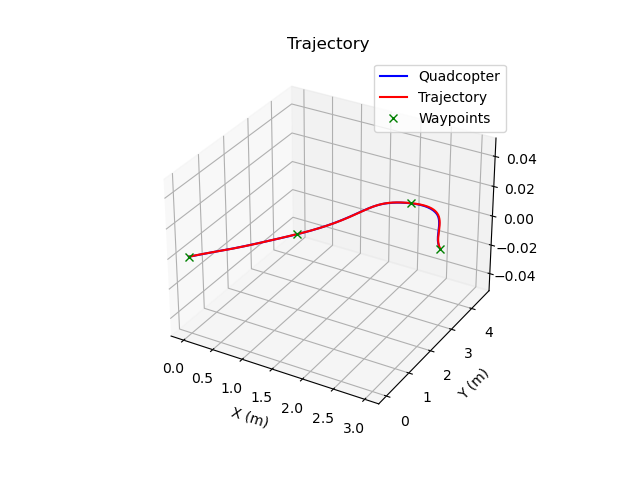

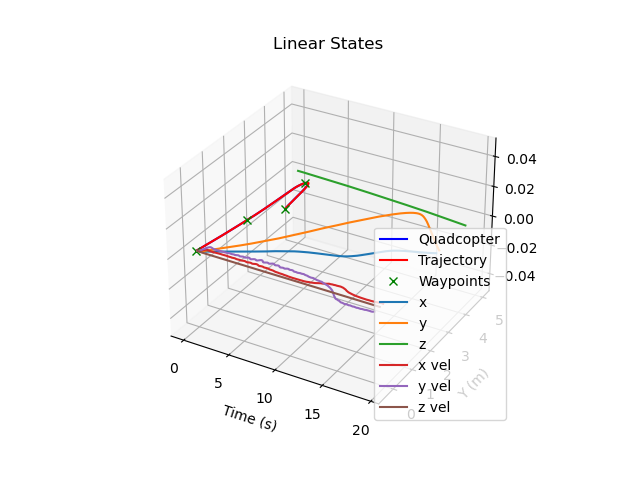

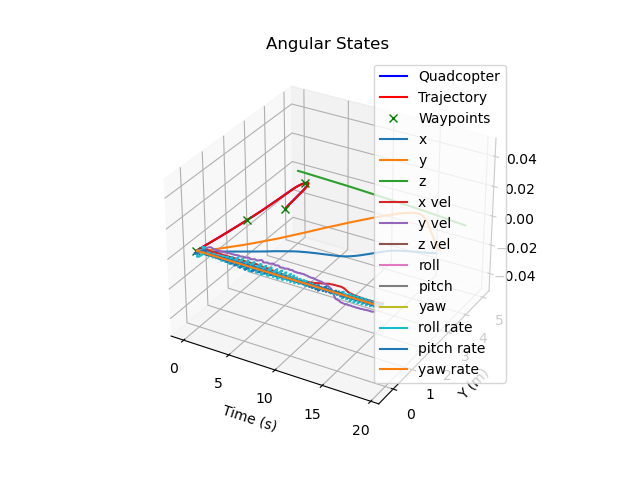

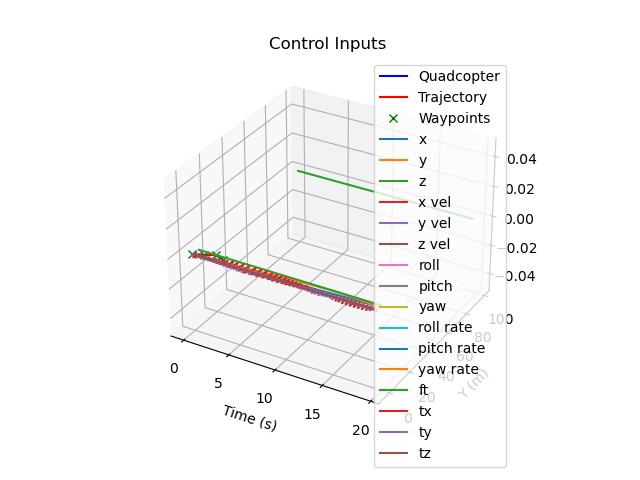

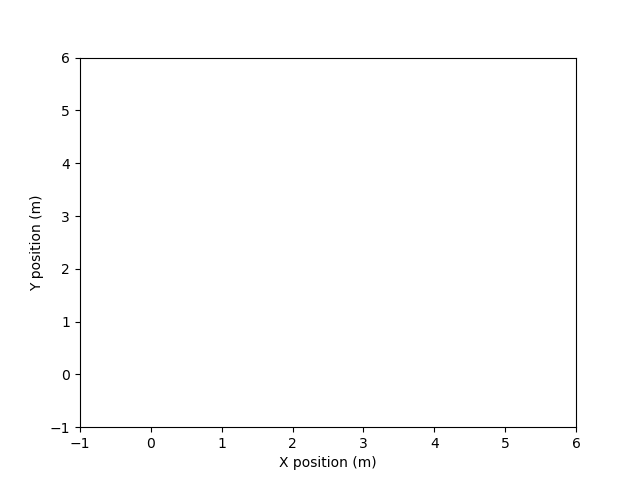

/home/mayank/anaconda3/envs/pytorch/lib/python3.10/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


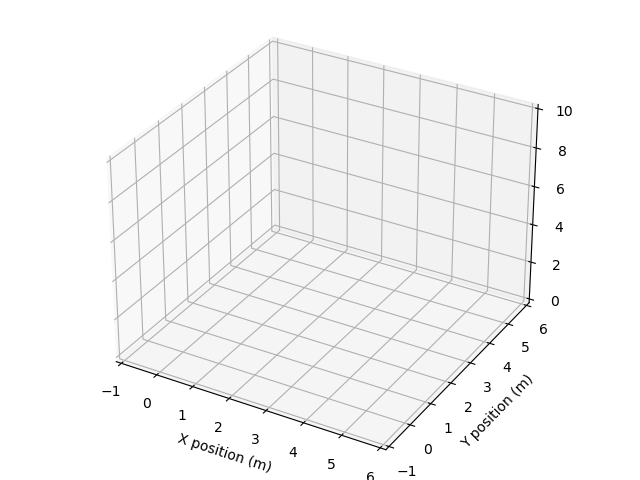

In [7]:
from MPC_control.quadcopter_MPC_Tyler import Quadcopter_MPC

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

q = Quadcopter_MPC()
q.run_simulation()